In [ ]:
!pip install pandas numpy sentence-transformers transformers matplotlib scikit-learn  concrete-ml

In [3]:
import json
import random
import numpy as np
import pandas as pd
#from tqdm.notebook import tqdm
from tqdm import tqdm
import pickle
#import pickle5 as pickle
import torch
import json
from time import time
from sentence_transformers import SentenceTransformer
#import tenseal as ts
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import precision_recall_curve, auc, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn import ensemble

In [8]:

# import the concrete-ml LinearSVC implementation
from concrete.ml.sklearn.svm import LinearSVC as ConcreteLinearSVC
from concrete.ml.sklearn import LogisticRegression as ConcreteLogisticRegression

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fc9a82e03a0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/opt/conda/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/opt/conda/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/opt/conda/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


In [7]:
pd.set_option('max_colwidth', 400)

In [5]:
train_df = pd.read_pickle("./train_data.pkl")
test_df = pd.read_pickle("./test_data.pkl")
dev_df = pd.read_pickle("./dev_data.pkl")

In [34]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8544 entries, 0 to 8543
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   label   8544 non-null   category
 1   text    8544 non-null   object  
dtypes: category(1), object(1)
memory usage: 75.3+ KB


In [36]:
train_df.head()

,label,text
0,4,"The Rock is destined to be the 21st Century 's new `` Conan '' and that he 's going to make a splash even greater than Arnold Schwarzenegger , Jean-Claud Van Damme or Steven Segal ."
1,5,The gorgeously elaborate continuation of `` The Lord of the Rings '' trilogy is so huge that a column of words can not adequately describe co-writer/director Peter Jackson 's expanded vision of J.R.R. Tolkien 's Middle-earth .
2,4,"Singer/composer Bryan Adams contributes a slew of songs -- a few potential hits , a few more simply intrusive to the story -- but the whole package certainly captures the intended , er , spirit of the piece ."
3,3,You 'd think by now America would have had enough of plucky British eccentrics with hearts of gold .
4,4,Yet the act is still charming here .


In [18]:
train_df.loc[train_df.label==1]

,label,text
45,1,... a sour little movie at its core ; an exploration of the emptiness that underlay the relentless gaiety of the 1920 's ... The film 's ending has a `` What was it all for ? ''
434,1,"As it is , it 's too long and unfocused ."
455,1,A decided lack of spontaneity in its execution and a dearth of real poignancy in its epiphanies .
459,1,"You 'll forget about it by Monday , though , and if they 're old enough to have developed some taste , so will your kids ."
605,1,The Ya-Ya 's have many secrets and one is - the books are better .
...,...,...
8530,1,... really horrible drek .
8534,1,Rashomon-for-dipsticks tale .
8537,1,Staggeringly dreadful romance .
8539,1,A real snooze .


In [17]:
train_df.label.unique()

[4, 5, 2, 1]
Categories (5, int64): [1, 2, 3, 4, 5]

In [7]:
# cleaning - remove the rows with label 3 (neutral)
train_df = train_df[train_df['label'] != 3]
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6920 entries, 0 to 8543
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   label   6920 non-null   category
 1   text    6920 non-null   object  
dtypes: category(1), object(1)
memory usage: 115.1+ KB


In [8]:
# cleaning - remove the rows with label 3 (neutral)
dev_df = dev_df[dev_df['label'] != 3]
dev_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 872 entries, 0 to 1100
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   label   872 non-null    category
 1   text    872 non-null    object  
dtypes: category(1), object(1)
memory usage: 14.7+ KB


In [9]:
# cleaning - remove the rows with label 3 (neutral)
test_df = test_df[test_df['label'] != 3]
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1821 entries, 1 to 2209
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   label   1821 non-null   category
 1   text    1821 non-null   object  
dtypes: category(1), object(1)
memory usage: 30.4+ KB


In [18]:
dev_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1101 entries, 0 to 1100
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   label   1101 non-null   category
 1   text    1101 non-null   object  
dtypes: category(1), object(1)
memory usage: 9.8+ KB


In [10]:
df_train = pd.concat([train_df, dev_df],axis=0, ignore_index=True)

In [11]:
df_train['label'] = df_train['label'].replace([2, 4], [1, 5])
test_df['label'] = test_df['label'].replace([2, 4], [1, 5])
df_train['label'].unique()

[5, 1]
Categories (3, int64): [1, 3, 5]

In [12]:
# 1 is negative, 0 is positive review

df_train['label'] = df_train['label'].replace([5], [0])
test_df['label'] = test_df['label'].replace([5], [0])
df_train['label'].unique()

[0, 1]
Categories (3, int64): [1, 3, 0]

In [22]:
df_train.loc[df_train.label==1].tail(20)

,label,text
7771,1,The film tries too hard to be funny and tries too hard to be hip .
7772,1,The end result is a film that 's neither .
7773,1,Every nanosecond of the The New Guy reminds you that you could be doing something else far more pleasurable .
7774,1,Something like scrubbing the toilet .
7775,1,Or emptying rat traps .
7776,1,Or doing last year 's taxes with your ex-wife .
7778,1,"/ But Daphne , you 're too Buff / Fred thinks he 's tough / And Velma - wow , you 've lost weight !"
7779,1,"Is the time really ripe for a warmed-over James Bond adventure , with a village idiot as the 007 clone ?"
7780,1,There 's enough melodrama in this Magnolia Primavera to make PTA proud yet director Muccino 's characters are less worthy of Puccini than they are of daytime television .
7781,1,"However it may please those who love movies that blare with pop songs , young science fiction fans will stomp away in disgust ."


In [13]:
test_df.describe()

,label,text
count,1821,1821
unique,2,1821
top,1,"If you sometimes like to go to the movies to have fun , Wasabi is a good place to start ."
freq,912,1


In [14]:
df_all = pd.concat([df_train, test_df],axis=0, ignore_index=True)
df_all.head()

,label,text
0,0,"The Rock is destined to be the 21st Century 's new `` Conan '' and that he 's going to make a splash even greater than Arnold Schwarzenegger , Jean-Claud Van Damme or Steven Segal ."
1,0,The gorgeously elaborate continuation of `` The Lord of the Rings '' trilogy is so huge that a column of words can not adequately describe co-writer/director Peter Jackson 's expanded vision of J.R.R. Tolkien 's Middle-earth .
2,0,"Singer/composer Bryan Adams contributes a slew of songs -- a few potential hits , a few more simply intrusive to the story -- but the whole package certainly captures the intended , er , spirit of the piece ."
3,0,Yet the act is still charming here .
4,0,"Whether or not you 're enlightened by any of Derrida 's lectures on `` the other '' and `` the self , '' Derrida is an undeniably fascinating and playful fellow ."


In [60]:
df_all.describe()

,label,text
count,9613,9613
unique,2,9602
top,0,What 's next ?
freq,4963,3


In [61]:
# Lets see how many words are in each review by creating the length column.
df_all['length'] = df_all['text'].str.split().apply(len).astype(int).round(1)
df_all.head()

,label,text,length
0,0,"The Rock is destined to be the 21st Century 's new `` Conan '' and that he 's going to make a splash even greater than Arnold Schwarzenegger , Jean-Claud Van Damme or Steven Segal .",36
1,0,The gorgeously elaborate continuation of `` The Lord of the Rings '' trilogy is so huge that a column of words can not adequately describe co-writer/director Peter Jackson 's expanded vision of J.R.R. Tolkien 's Middle-earth .,37
2,0,"Singer/composer Bryan Adams contributes a slew of songs -- a few potential hits , a few more simply intrusive to the story -- but the whole package certainly captures the intended , er , spirit of the piece .",39
3,0,Yet the act is still charming here .,8
4,0,"Whether or not you 're enlightened by any of Derrida 's lectures on `` the other '' and `` the self , '' Derrida is an undeniably fascinating and playful fellow .",32


In [70]:
df_all.describe()

,length
count,9613.000000
mean,19.309685
std,9.194963
min,2.000000
25%,12.000000
50%,19.000000
75%,25.000000
max,56.000000


<Axes: ylabel='Frequency'>

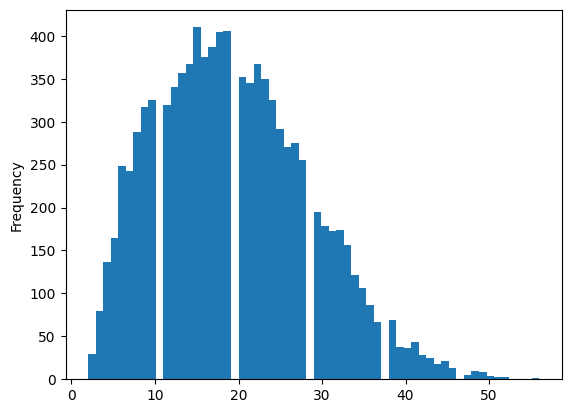

In [63]:
# Lets see the disribution of the review lengths
df_all['length'].plot(bins = 60, kind = 'hist')

In [64]:
print(f'Number of negative examples: {len(df_all.loc[df_all.label==0])}')
print(f'Number of positive examples: {len(df_all.loc[df_all.label==1])}')

Number of negative examples: 4963
Number of positive examples: 4650


In [65]:
y = df_all['label']

In [67]:
 y.value_counts().sum()

9613

In [68]:
pos_ratio = y.value_counts()[1] / y.value_counts().sum()
neg_ratio = y.value_counts()[0] / y.value_counts().sum()

print(f'Proportion of positive examples: {round(pos_ratio * 100, 2)}%')
print(f'Proportion of negative examples: {round(neg_ratio * 100, 2)}%')

Proportion of positive examples: 48.37%
Proportion of negative examples: 51.63%


### Embeddings

In [17]:
# a model for 3 class sentiment
model_roberta_s3 = SentenceTransformer('/root/data/pretrained_models/sentiment-roberta-large-english-3-classes')

No sentence-transformers model found with name /root/data/pretrained_models/sentiment-roberta-large-english-3-classes. Creating a new one with MEAN pooling.


In [19]:
# Do encoding in batches
embeddings = []
batch_size = 64
batch = []
for row in tqdm(df_train.itertuples()):
    description =row.text
    batch.append(description)
    if len(batch) >= batch_size:
        embeddings.append(model_roberta_s3.encode(batch))  # Text -> vector encoding happens here
        batch = []

if len(batch) > 0:
    embeddings.append(model_roberta_s3.encode(batch))
    batch = []

embeddings = np.concatenate(embeddings)

7792it [02:19, 55.70it/s]


In [20]:
sentences = df_train['text']
labels = df_train['label']

In [21]:
#Store sentences & embeddings 
with open('./embeddings_sent_train_sstb_2.pkl', "wb") as fOut:
    pickle.dump({'sentences': sentences, 'embeddings': embeddings, 'labels': labels}, fOut, protocol=pickle.HIGHEST_PROTOCOL)

In [22]:
# Do encoding in batches
embeddings = []
batch_size = 64
batch = []
for row in tqdm(test_df.itertuples()):
    description =row.text
    batch.append(description)
    if len(batch) >= batch_size:
        embeddings.append(model_roberta_s3.encode(batch))  # Text -> vector encoding happens here
        batch = []

if len(batch) > 0:
    embeddings.append(model_roberta_s3.encode(batch))
    batch = []

embeddings = np.concatenate(embeddings)

1821it [00:33, 55.17it/s]


In [23]:
sentences = test_df['text']
labels = test_df['label']

In [24]:
#Store sentences & embeddings 
with open('./embeddings_sent_test_sstb_2.pkl', "wb") as fOut:
    pickle.dump({'sentences': sentences, 'embeddings': embeddings, 'labels': labels}, fOut, protocol=pickle.HIGHEST_PROTOCOL)

In [9]:
#Load sentences & embeddings from disc
with open('./embeddings_sent_train_sstb_2.pkl', "rb") as fIn:
    stored_data = pickle.load(fIn)
    sentences_train = stored_data['sentences']
    embeddings_train = stored_data['embeddings']
    labels_train = stored_data['labels']  

In [10]:
#Load sentences & embeddings from disc
with open('./embeddings_sent_test_sstb_2.pkl', "rb") as fIn:
    stored_data = pickle.load(fIn)
    sentences_test = stored_data['sentences']
    embeddings_test = stored_data['embeddings']
    labels_test = stored_data['labels']  

### PCA features

In [11]:
print(embeddings_train.shape)
print(labels_train.shape)
print(embeddings_test.shape)
print(labels_test.shape)

(7792, 1024)
(7792,)
(1821, 1024)
(1821,)


In [12]:
X_train = embeddings_train
y_train = labels_train

X_test = embeddings_test
y_test = labels_test

In [13]:
X_train = StandardScaler(with_std=True).fit_transform(X_train)

In [14]:
pca_train = PCA(n_components=20)
pca_test = PCA(n_components=20)

X_reduced_dimension_train = pca_train.fit_transform(X_train)
X_reduced_dimension_test = pca_test.fit_transform(X_test)

In [80]:
print('Cumulative explained variation for 80 principal components: {}'.format(np.sum(pca_train.explained_variance_ratio_)))

Cumulative explained variation for 80 principal components: 0.9342116117477417


In [10]:
print('Cumulative explained variation for 60 principal components: {}'.format(np.sum(pca_test.explained_variance_ratio_)))

Cumulative explained variation for 60 principal components: 0.9252608418464661


In [10]:
print('Cumulative explained variation for 20 principal components: {}'.format(np.sum(pca_test.explained_variance_ratio_)))

Cumulative explained variation for 20 principal components: 0.8743910193443298


In [12]:
print('Cumulative explained variation for 10 principal components: {}'.format(np.sum(pca_test.explained_variance_ratio_)))

Cumulative explained variation for 10 principal components: 0.8409968614578247


In [11]:
#Store sentences & embeddings 
with open('./embeddings_sent_train_sstb_pca_20.pkl', "wb") as fOut:
    pickle.dump({'embeddings': X_reduced_dimension_train, 'labels': labels_train}, fOut, protocol=pickle.HIGHEST_PROTOCOL)

In [12]:
#Store sentences & embeddings 
with open('./embeddings_sent_test_sstb_pca_20.pkl', "wb") as fOut:
    pickle.dump({ 'embeddings': X_reduced_dimension_test, 'labels': labels_test}, fOut, protocol=pickle.HIGHEST_PROTOCOL)

In [15]:
#Load sentences & embeddings from disc
with open('./embeddings_sent_train_sstb_pca_20.pkl', "rb") as fIn:
    stored_data = pickle.load(fIn)
    embeddings_train = stored_data['embeddings']
    labels_train = stored_data['labels']  

In [16]:
#Load sentences & embeddings from disc
with open('./embeddings_sent_test_sstb_pca_20.pkl', "rb") as fIn:
    stored_data = pickle.load(fIn)
    embeddings_test = stored_data['embeddings']
    labels_test = stored_data['labels']  

### Encrypting in Concrete ML

### Plain model

In [17]:
X_train = StandardScaler(with_std=True).fit_transform(embeddings_train)
X_train.shape

(7792, 20)

In [18]:
y_train = labels_train

In [17]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size = 0.18, random_state = 10)

In [19]:
X_test = embeddings_test
X_test.shape

(1821, 20)

In [20]:
y_test = labels_test

### Logistic regression

In [28]:
# parameter grid
parameters = {
    'penalty' : ['l2'], 
    'C'       : np.logspace(0.1, 1, 10, 12),
    'solver'  : ['lbfgs'],
}

In [19]:
import warnings
warnings.filterwarnings("ignore")

In [21]:
logreg = LogisticRegression( class_weight = 'balanced')
clf = GridSearchCV(logreg,                    # model
                   param_grid = parameters,   # hyperparameters
                   scoring= 'f1_macro',        # metric for scoring
                   cv=8)    # number of folds #, refit= False

clf.fit(X_train, y_train)
print("Tuned Hyperparameters :", clf.best_params_)

Tuned Hyperparameters : {'C': 1.2589254117941673, 'penalty': 'l2', 'solver': 'lbfgs'}


In [24]:
# parameter grid
parameters = {
    'penalty' : ['l2'], 
    'C'       : np.logspace(0.1, 1, 10, 12),
    'solver'  : ['saga'],
}

In [22]:
# instantiate the model
t_start = time()
logreg = LogisticRegression(solver='lbfgs', C= 1.2589254117941673, class_weight = 'balanced', penalty= 'l2', random_state=15)  # C= 1.2589
# fit the model
logreg.fit(X_train, y_train)
t_end = time()
print(f"Model fitting to training data took {int(t_end - t_start)} seconds")

Model fitting to training data took 0 seconds


In [23]:
# prediction
y_pred_test = logreg.predict(X_test)

In [25]:
#20 pca
print(classification_report(y_test, y_pred_test, digits=4))

              precision    recall  f1-score   support

           0     0.8190    0.8812    0.8490       909
           1     0.8719    0.8059    0.8376       912

    accuracy                         0.8435      1821
   macro avg     0.8455    0.8436    0.8433      1821
weighted avg     0.8455    0.8435    0.8433      1821



In [26]:
print('Accuracy : {0:0.4f}'.format(accuracy_score(y_test, y_pred_test)))
print('Precision score: {0:0.4f}'. format(precision_score(y_test, y_pred_test, average='macro')))
print('F1 score : {0:0.4f}'.format(f1_score(y_test, y_pred_test,average='macro' )))
# calculate precision-recall AUC
auc_prc = roc_auc_score(y_test, logreg.predict_proba(X_test)[:,1], average='macro', multi_class='ovr')
print('AUC Precision-Recall: {0:0.4f}'.format(auc_prc))

Accuracy : 0.8435
Precision score: 0.8455
F1 score : 0.8433
AUC Precision-Recall: 0.9231


In [55]:
print(classification_report(y_test, y_pred_test, digits=4))

              precision    recall  f1-score   support

           0     0.9746    0.8031    0.8806       909
           1     0.8330    0.9792    0.9002       912

    accuracy                         0.8913      1821
   macro avg     0.9038    0.8911    0.8904      1821
weighted avg     0.9037    0.8913    0.8904      1821



In [56]:
print('Accuracy : {0:0.4f}'.format(accuracy_score(y_test, y_pred_test)))
print('Precision score: {0:0.4f}'. format(precision_score(y_test, y_pred_test, average='macro')))
print('F1 score : {0:0.4f}'.format(f1_score(y_test, y_pred_test,average='macro' )))
# calculate precision-recall AUC
auc_prc = roc_auc_score(y_test, logreg.predict_proba(X_test)[:,1], average='macro', multi_class='ovr')
print('AUC Precision-Recall: {0:0.4f}'.format(auc_prc))

Accuracy : 0.8913
Precision score: 0.9038
F1 score : 0.8904
AUC Precision-Recall: 0.9634


In [44]:
logreg = LogisticRegression( class_weight = 'balanced')
clf = GridSearchCV(logreg,                    # model
                   param_grid = parameters,   # hyperparameters
                   scoring= 'f1_macro',        # metric for scoring
                   cv=8)    # number of folds #, refit= False

clf.fit(X_train, y_train)
print("Tuned Hyperparameters :", clf.best_params_)

Tuned Hyperparameters : {'C': 1.2589254117941673, 'penalty': 'l2', 'solver': 'lbfgs'}


In [36]:
# instantiate the model
t_start = time()
logreg = LogisticRegression(solver='saga', C= 10.0, class_weight = 'balanced', penalty= 'l2', random_state=16)  # C= 1.2589
# fit the model
logreg.fit(X_train, y_train)
t_end = time()
print(f"Model fitting to training data took {int(t_end - t_start)} seconds")

Model fitting to training data took 8 seconds


In [37]:
# prediction
y_pred_test = logreg.predict(X_test)

In [38]:
print(classification_report(y_test, y_pred_test, digits=4))

              precision    recall  f1-score   support

           0     0.9793    0.7811    0.8690       909
           1     0.8184    0.9836    0.8934       912

    accuracy                         0.8825      1821
   macro avg     0.8989    0.8823    0.8812      1821
weighted avg     0.8987    0.8825    0.8812      1821



In [39]:
print('Accuracy : {0:0.4f}'.format(accuracy_score(y_test, y_pred_test)))
print('Precision score: {0:0.4f}'. format(precision_score(y_test, y_pred_test, average='macro')))
print('F1 score : {0:0.4f}'.format(f1_score(y_test, y_pred_test,average='macro' )))
# calculate precision-recall AUC
auc_prc = roc_auc_score(y_test, logreg.predict_proba(X_test)[:,1], average='macro', multi_class='ovr')
print('AUC Precision-Recall: {0:0.4f}'.format(auc_prc))

Accuracy : 0.8825
Precision score: 0.8989
F1 score : 0.8812
AUC Precision-Recall: 0.9725


### Encrypted model

In [25]:
lg_enc = ConcreteLogisticRegression( class_weight = 'balanced')
clf_enc = GridSearchCV(lg_enc,                    # model
                   param_grid = parameters,   # hyperparameters
                   scoring= 'f1_macro',        # metric for scoring
                   cv=8)    # number of folds #, refit= False

clf_enc.fit(X_train, y_train)
print("Tuned Hyperparameters :", clf_enc.best_params_)

Tuned Hyperparameters : {'C': 1.9952623149688797, 'penalty': 'l2', 'solver': 'saga'}


In [29]:
# 20 pca
lg_enc = ConcreteLogisticRegression( class_weight = 'balanced')
clf_enc = GridSearchCV(lg_enc,                    # model
                   param_grid = parameters,   # hyperparameters
                   scoring= 'f1_macro',        # metric for scoring
                   cv=8)    # number of folds #, refit= False

clf_enc.fit(X_train, y_train)
print("Tuned Hyperparameters :", clf_enc.best_params_)

Tuned Hyperparameters : {'C': 1.2589254117941673, 'penalty': 'l2', 'solver': 'lbfgs'}


In [30]:
# instantiate the model
t_start = time()
lg_concrete = ConcreteLogisticRegression(solver='lbfgs', C= 1.2589254117941673, class_weight = 'balanced', penalty= 'l2', n_bits=8, random_state=15)  
# fit the model
lg_concrete.fit(X_train, y_train)
t_end = time()
print(f"Model fitting to training data took {int(t_end - t_start)} seconds")

Model fitting to training data took 0 seconds


In [31]:
t_start = time()
# A circuit needs to be compiled to enable FHE execution
circuit = lg_concrete.compile(X_train)
# Now that a circuit is compiled, the svm_concrete can predict value with FHE
y_pred_enc = lg_concrete.predict(X_test, fhe="execute")
t_end = time()
print(f" Encrypted Model fitting to data took {int(t_end - t_start)} seconds")

 Encrypted Model fitting to data took 4 seconds


In [32]:
## 20 pca

print(classification_report(y_test, y_pred_enc, digits=4))

              precision    recall  f1-score   support

           0     0.8068    0.8911    0.8468       909
           1     0.8788    0.7873    0.8305       912

    accuracy                         0.8391      1821
   macro avg     0.8428    0.8392    0.8387      1821
weighted avg     0.8429    0.8391    0.8387      1821



In [33]:
print('Accuracy : {0:0.4f}'.format(accuracy_score(y_test, y_pred_enc)))
print('Precision score: {0:0.4f}'.format(precision_score(y_test, y_pred_enc, average='macro')))
print('F1 score : {0:0.4f}'.format(f1_score(y_test, y_pred_enc,average='macro' )))

auc_prc = roc_auc_score(y_test, lg_concrete.predict_proba(X_test)[:,1], average='macro',multi_class='ovr')
print('AUC Precision-Recall: {0:0.4f}'.format(auc_prc))

Accuracy : 0.8391
Precision score: 0.8428
F1 score : 0.8387
AUC Precision-Recall: 0.9208


In [26]:
# instantiate the model
t_start = time()
lg_concrete = ConcreteLogisticRegression(solver='saga', C= 1.9952623149688797, class_weight = 'balanced', penalty= 'l2', n_bits=8, random_state=15)  
# fit the model
lg_concrete.fit(X_train, y_train)
t_end = time()
print(f"Model fitting to training data took {int(t_end - t_start)} seconds")

Model fitting to training data took 9 seconds


In [28]:
t_start = time()
# A circuit needs to be compiled to enable FHE execution
circuit = lg_concrete.compile(X_train)
# Now that a circuit is compiled, the svm_concrete can predict value with FHE
y_pred_enc = lg_concrete.predict(X_test, fhe="execute")
t_end = time()
print(f" Encrypted Model fitting to data took {int(t_end - t_start)} seconds")

 Encrypted Model fitting to data took 94 seconds


In [29]:
## saga

print(classification_report(y_test, y_pred_enc, digits=4))

              precision    recall  f1-score   support

           0     0.9794    0.7855    0.8718       909
           1     0.8214    0.9836    0.8952       912

    accuracy                         0.8847      1821
   macro avg     0.9004    0.8845    0.8835      1821
weighted avg     0.9003    0.8847    0.8835      1821



In [30]:
print('Accuracy : {0:0.4f}'.format(accuracy_score(y_test, y_pred_enc)))
print('Precision score: {0:0.4f}'.format(precision_score(y_test, y_pred_enc, average='macro')))
print('F1 score : {0:0.4f}'.format(f1_score(y_test, y_pred_enc,average='macro' )))

auc_prc = roc_auc_score(y_test, lg_concrete.predict_proba(X_test)[:,1], average='macro',multi_class='ovr')
print('AUC Precision-Recall: {0:0.4f}'.format(auc_prc))

Accuracy : 0.8847
Precision score: 0.9004
F1 score : 0.8835
AUC Precision-Recall: 0.9723


In [32]:
# instantiate the model
t_start = time()
lg_concrete = ConcreteLogisticRegression(solver='lbfgs', C= 1.2589254117941673, class_weight = 'balanced', penalty= 'l2', n_bits=8, random_state=15)  
# fit the model
lg_concrete.fit(X_train, y_train)
t_end = time()
print(f"Model fitting to training data took {int(t_end - t_start)} seconds")

Model fitting to training data took 0 seconds


In [33]:
t_start = time()
# A circuit needs to be compiled to enable FHE execution
circuit = lg_concrete.compile(X_train)
# Now that a circuit is compiled, the svm_concrete can predict value with FHE
y_pred_enc = lg_concrete.predict(X_test, fhe="execute")
t_end = time()
print(f" Encrypted Model fitting to data took {int(t_end - t_start)} seconds")

 Encrypted Model fitting to data took 94 seconds


In [34]:
## lbfgs

print(classification_report(y_test, y_pred_enc, digits=4))

              precision    recall  f1-score   support

           0     0.9747    0.8053    0.8819       909
           1     0.8346    0.9792    0.9011       912

    accuracy                         0.8924      1821
   macro avg     0.9046    0.8922    0.8915      1821
weighted avg     0.9045    0.8924    0.8915      1821



In [35]:
print('Accuracy : {0:0.4f}'.format(accuracy_score(y_test, y_pred_enc)))
print('Precision score: {0:0.4f}'.format(precision_score(y_test, y_pred_enc, average='macro')))
print('F1 score : {0:0.4f}'.format(f1_score(y_test, y_pred_enc,average='macro' )))

auc_prc = roc_auc_score(y_test, lg_concrete.predict_proba(X_test)[:,1], average='macro',multi_class='ovr')
print('AUC Precision-Recall: {0:0.4f}'.format(auc_prc))

Accuracy : 0.8924
Precision score: 0.9046
F1 score : 0.8915
AUC Precision-Recall: 0.9632


In [45]:
# instantiate the model
t_start = time()
lg_concrete = ConcreteLogisticRegression(solver='lbfgs', C= 1.2589254117941673, class_weight = 'balanced', penalty= 'l2', n_bits=6, random_state=15)  
# fit the model
lg_concrete.fit(X_train, y_train)
t_end = time()
print(f"Model fitting to training data took {int(t_end - t_start)} seconds")

Model fitting to training data took 0 seconds


In [46]:
t_start = time()
# A circuit needs to be compiled to enable FHE execution
circuit = lg_concrete.compile(X_train)
# Now that a circuit is compiled, the svm_concrete can predict value with FHE
y_pred_enc = lg_concrete.predict(X_test, fhe="execute")
t_end = time()
print(f" Encrypted Model fitting to data took {int(t_end - t_start)} seconds")

 Encrypted Model fitting to data took 80 seconds


In [47]:
print(classification_report(y_test, y_pred_enc, digits=4))

              precision    recall  f1-score   support

           0     0.9709    0.8086    0.8824       909
           1     0.8365    0.9759    0.9008       912

    accuracy                         0.8924      1821
   macro avg     0.9037    0.8922    0.8916      1821
weighted avg     0.9036    0.8924    0.8916      1821



In [48]:
print('Accuracy : {0:0.4f}'.format(accuracy_score(y_test, y_pred_enc)))
print('Precision score: {0:0.4f}'.format(precision_score(y_test, y_pred_enc, average='macro')))
print('F1 score : {0:0.4f}'.format(f1_score(y_test, y_pred_enc,average='macro' )))

auc_prc = roc_auc_score(y_test, lg_concrete.predict_proba(X_test)[:,1], average='macro',multi_class='ovr')
print('AUC Precision-Recall: {0:0.4f}'.format(auc_prc))

Accuracy : 0.8924
Precision score: 0.9037
F1 score : 0.8916
AUC Precision-Recall: 0.9655


In [49]:
# instantiate the model
t_start = time()
lg_concrete = ConcreteLogisticRegression(solver='lbfgs', C= 1.2589254117941673, class_weight = 'balanced', penalty= 'l2', n_bits=4, random_state=15)  
# fit the model
lg_concrete.fit(X_train, y_train)
t_end = time()
print(f"Model fitting to training data took {int(t_end - t_start)} seconds")

Model fitting to training data took 0 seconds


In [50]:
t_start = time()
# A circuit needs to be compiled to enable FHE execution
circuit = lg_concrete.compile(X_train)
# Now that a circuit is compiled, the svm_concrete can predict value with FHE
y_pred_enc = lg_concrete.predict(X_test, fhe="execute")
t_end = time()
print(f" Encrypted Model fitting to data took {int(t_end - t_start)} seconds")

 Encrypted Model fitting to data took 69 seconds


In [51]:
print(classification_report(y_test, y_pred_enc, digits=4))

              precision    recall  f1-score   support

           0     0.9185    0.8064    0.8588       909
           1     0.8280    0.9287    0.8755       912

    accuracy                         0.8677      1821
   macro avg     0.8733    0.8676    0.8671      1821
weighted avg     0.8732    0.8677    0.8671      1821



In [52]:
print('Accuracy : {0:0.4f}'.format(accuracy_score(y_test, y_pred_enc)))
print('Precision score: {0:0.4f}'.format(precision_score(y_test, y_pred_enc, average='macro')))
print('F1 score : {0:0.4f}'.format(f1_score(y_test, y_pred_enc,average='macro' )))

auc_prc = roc_auc_score(y_test, lg_concrete.predict_proba(X_test)[:,1], average='macro',multi_class='ovr')
print('AUC Precision-Recall: {0:0.4f}'.format(auc_prc))

Accuracy : 0.8677
Precision score: 0.8733
F1 score : 0.8671
AUC Precision-Recall: 0.9328


### SVM Model  

In [50]:
t_start = time()
clf = LinearSVC(multi_class='ovr',class_weight ='balanced', random_state=15).fit(X_train, y_train)
t_end = time()
print(f"Model fitting to training data took {int(t_end - t_start)} seconds")

Model fitting to training data took 0 seconds


In [51]:
y_pred = clf.predict(X_test)

In [52]:
# 20 pca
print(classification_report(y_test, y_pred, digits =4))

              precision    recall  f1-score   support

           0     0.8111    0.8834    0.8457       909
           1     0.8724    0.7950    0.8319       912

    accuracy                         0.8391      1821
   macro avg     0.8418    0.8392    0.8388      1821
weighted avg     0.8418    0.8391    0.8388      1821



In [53]:
print('Accuracy : {0:0.4f}'.format(accuracy_score(y_test, y_pred)))
print('Precision score: {0:0.4f}'.format(precision_score(y_test, y_pred, average='macro')))
print('F1 score : {0:0.4f}'.format(f1_score(y_test, y_pred,average='macro' )))

auc_prc = roc_auc_score(y_test, clf._predict_proba_lr(X_test)[:,1], average='macro',multi_class='ovr')
print('AUC Precision-Recall: {0:0.4f}'.format(auc_prc))

Accuracy : 0.8391
Precision score: 0.8418
F1 score : 0.8388
AUC Precision-Recall: 0.9372


In [59]:
print(classification_report(y_test, y_pred, digits =4))

              precision    recall  f1-score   support

           0     0.8758    0.8999    0.8877       909
           1     0.8974    0.8728    0.8849       912

    accuracy                         0.8863      1821
   macro avg     0.8866    0.8863    0.8863      1821
weighted avg     0.8866    0.8863    0.8863      1821



In [60]:
print('Accuracy : {0:0.4f}'.format(accuracy_score(y_test, y_pred)))
print('Precision score: {0:0.4f}'.format(precision_score(y_test, y_pred, average='macro')))
print('F1 score : {0:0.4f}'.format(f1_score(y_test, y_pred,average='macro' )))

auc_prc = roc_auc_score(y_test, clf._predict_proba_lr(X_test)[:,1], average='macro',multi_class='ovr')
print('AUC Precision-Recall: {0:0.4f}'.format(auc_prc))

Accuracy : 0.8863
Precision score: 0.8866
F1 score : 0.8863
AUC Precision-Recall: 0.9634


### Encrypted SVM

In [42]:
t_start = time()
clf_concrete = ConcreteLinearSVC(multi_class='ovr',class_weight ='balanced', n_bits=8, random_state=15).fit(X_train, y_train)
t_end = time()
print(f" Encrypted Model fitting to data took {int(t_end - t_start)} seconds")

 Encrypted Model fitting to data took 0 seconds


In [47]:
t_start = time()
# A circuit needs to be compiled to enable FHE execution
circuit = clf_concrete.compile(X_train)
# Now that a circuit is compiled, the svm_concrete can predict value with FHE
y_pred_enc = clf_concrete.predict(X_test, fhe="execute")
t_end = time()
print(f" Encrypted Model fitting to data took {int(t_end - t_start)} seconds")

 Encrypted Model fitting to data took 3 seconds


In [44]:
# 20 pca
print(classification_report(y_test,y_pred_enc, digits=4))

              precision    recall  f1-score   support

           0     0.8068    0.8911    0.8468       909
           1     0.8788    0.7873    0.8305       912

    accuracy                         0.8391      1821
   macro avg     0.8428    0.8392    0.8387      1821
weighted avg     0.8429    0.8391    0.8387      1821



In [45]:
print('Accuracy : {0:0.4f}'.format(accuracy_score(y_test, y_pred_enc)))
print('Precision score: {0:0.4f}'.format(precision_score(y_test, y_pred_enc, average='macro')))
print('F1 score : {0:0.4f}'.format(f1_score(y_test, y_pred_enc,average='macro' )))

auc_prc = roc_auc_score(y_test, clf_concrete.predict_proba(X_test)[:,1], average='macro',multi_class='ovr')
print('AUC Precision-Recall: {0:0.4f}'.format(auc_prc))

Accuracy : 0.8391
Precision score: 0.8428
F1 score : 0.8387
AUC Precision-Recall: 0.9190


In [46]:
t_start = time()
clf_concrete = ConcreteLinearSVC(multi_class='ovr',class_weight ='balanced', n_bits=6, random_state=15).fit(X_train, y_train)
t_end = time()
print(f" Encrypted Model fitting to data took {int(t_end - t_start)} seconds")

 Encrypted Model fitting to data took 0 seconds


In [48]:
print(classification_report(y_test,y_pred_enc, digits=4))

              precision    recall  f1-score   support

           0     0.8068    0.8911    0.8468       909
           1     0.8788    0.7873    0.8305       912

    accuracy                         0.8391      1821
   macro avg     0.8428    0.8392    0.8387      1821
weighted avg     0.8429    0.8391    0.8387      1821



In [49]:
print('Accuracy : {0:0.4f}'.format(accuracy_score(y_test, y_pred_enc)))
print('Precision score: {0:0.4f}'.format(precision_score(y_test, y_pred_enc, average='macro')))
print('F1 score : {0:0.4f}'.format(f1_score(y_test, y_pred_enc,average='macro' )))

auc_prc = roc_auc_score(y_test, clf_concrete.predict_proba(X_test)[:,1], average='macro',multi_class='ovr')
print('AUC Precision-Recall: {0:0.4f}'.format(auc_prc))

Accuracy : 0.8391
Precision score: 0.8428
F1 score : 0.8387
AUC Precision-Recall: 0.9181


In [75]:
print(classification_report(y_test,y_pred_enc, digits=4))

              precision    recall  f1-score   support

           0     0.8766    0.8988    0.8876       909
           1     0.8965    0.8739    0.8851       912

    accuracy                         0.8863      1821
   macro avg     0.8866    0.8863    0.8863      1821
weighted avg     0.8866    0.8863    0.8863      1821



In [76]:
print('Accuracy : {0:0.4f}'.format(accuracy_score(y_test, y_pred_enc)))
print('Precision score: {0:0.4f}'.format(precision_score(y_test, y_pred_enc, average='macro')))
print('F1 score : {0:0.4f}'.format(f1_score(y_test, y_pred_enc,average='macro' )))

auc_prc = roc_auc_score(y_test, clf_concrete.predict_proba(X_test)[:,1], average='macro',multi_class='ovr')
print('AUC Precision-Recall: {0:0.4f}'.format(auc_prc))

Accuracy : 0.8863
Precision score: 0.8866
F1 score : 0.8863
AUC Precision-Recall: 0.9444


In [65]:
t_start = time()
clf_concrete = ConcreteLinearSVC(multi_class='ovr',class_weight ='balanced', n_bits=6, random_state=15).fit(X_train, y_train)
t_end = time()
print(f" Encrypted Model fitting to data took {int(t_end - t_start)} seconds")

 Encrypted Model fitting to data took 8 seconds


In [66]:
t_start = time()
# A circuit needs to be compiled to enable FHE execution
circuit = clf_concrete.compile(X_train)
# Now that a circuit is compiled, the svm_concrete can predict value with FHE
y_pred_enc = clf_concrete.predict(X_test, fhe="execute")
t_end = time()
print(f" Encrypted Model fitting to data took {int(t_end - t_start)} seconds")

 Encrypted Model fitting to data took 75 seconds


In [67]:
print(classification_report(y_test, y_pred_enc, digits=4))

              precision    recall  f1-score   support

           0     0.8857    0.8691    0.8773       909
           1     0.8719    0.8882    0.8800       912

    accuracy                         0.8786      1821
   macro avg     0.8788    0.8786    0.8786      1821
weighted avg     0.8788    0.8786    0.8786      1821



In [68]:
print('Accuracy : {0:0.4f}'.format(accuracy_score(y_test, y_pred_enc)))
print('Precision score: {0:0.4f}'.format(precision_score(y_test, y_pred_enc, average='macro')))
print('F1 score : {0:0.4f}'.format(f1_score(y_test, y_pred_enc,average='macro' )))

auc_prc = roc_auc_score(y_test, clf_concrete.predict_proba(X_test)[:,1], average='macro',multi_class='ovr')
print('AUC Precision-Recall: {0:0.4f}'.format(auc_prc))

Accuracy : 0.8786
Precision score: 0.8788
F1 score : 0.8786
AUC Precision-Recall: 0.9424


In [69]:
t_start = time()
clf_concrete = ConcreteLinearSVC(multi_class='ovr',class_weight ='balanced', n_bits=4, random_state=15).fit(X_train, y_train)
t_end = time()
print(f" Encrypted Model fitting to data took {int(t_end - t_start)} seconds")

 Encrypted Model fitting to data took 8 seconds


In [70]:
t_start = time()
# A circuit needs to be compiled to enable FHE execution
circuit = clf_concrete.compile(X_train)
# Now that a circuit is compiled, the svm_concrete can predict value with FHE
y_pred_enc = clf_concrete.predict(X_test, fhe="execute")
t_end = time()
print(f" Encrypted Model fitting to data took {int(t_end - t_start)} seconds")

 Encrypted Model fitting to data took 70 seconds


In [71]:
print(classification_report(y_test,y_pred_enc, digits=4))

              precision    recall  f1-score   support

           0     0.8405    0.8636    0.8519       909
           1     0.8602    0.8366    0.8482       912

    accuracy                         0.8501      1821
   macro avg     0.8503    0.8501    0.8501      1821
weighted avg     0.8504    0.8501    0.8501      1821



In [72]:
print('Accuracy : {0:0.4f}'.format(accuracy_score(y_test, y_pred_enc)))
print('Precision score: {0:0.4f}'.format(precision_score(y_test, y_pred_enc, average='macro')))
print('F1 score : {0:0.4f}'.format(f1_score(y_test, y_pred_enc,average='macro' )))

auc_prc = roc_auc_score(y_test, clf_concrete.predict_proba(X_test)[:,1], average='macro',multi_class='ovr')
print('AUC Precision-Recall: {0:0.4f}'.format(auc_prc))

Accuracy : 0.8501
Precision score: 0.8503
F1 score : 0.8501
AUC Precision-Recall: 0.9219


### XGBoost

In [76]:
# Let's build our model
xbmodel = ensemble.GradientBoostingClassifier()
# A gridsearch to find the best parameters
parameters = {
#    "n_bits": [4,6],
    "max_depth": [6],
    "n_estimators": [60,80],
    "learning_rate": [0.01, 0.1]

}

# Now we have a representation for each tweet, we can train a model on these.
grid_search = GridSearchCV(xbmodel, parameters, cv=8, scoring="f1_macro")
grid_search.fit(X_train, y_train)

# Check the accuracy of the best model
print(f"Best score: {grid_search.best_score_}")

# Check best hyperparameters
print(f"Best parameters: {grid_search.best_params_}")

# Extract best model
best_model = grid_search.best_estimator_

Best score: 0.9039077923595649
Best parameters: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 60}


In [80]:
t_start = time()
clf = ensemble.GradientBoostingClassifier(n_estimators=60, learning_rate=0.01, max_depth=6, random_state=15).fit(X_train, y_train)
t_end = time()
print(f"Model fitting to training data took {int(t_end - t_start)} seconds")

Model fitting to training data took 5 seconds


In [81]:
y_pred = clf.predict(X_test)

In [ ]:
# 20 pca

In [82]:
print(classification_report(y_test, y_pred, digits =4))

              precision    recall  f1-score   support

           0     0.7351    0.7756    0.7548       909
           1     0.7633    0.7215    0.7418       912

    accuracy                         0.7485      1821
   macro avg     0.7492    0.7485    0.7483      1821
weighted avg     0.7493    0.7485    0.7483      1821



In [83]:
print('Accuracy : {0:0.4f}'.format(accuracy_score(y_test, y_pred)))
print('Precision score: {0:0.4f}'.format(precision_score(y_test, y_pred, average='macro')))
print('F1 score : {0:0.4f}'.format(f1_score(y_test, y_pred,average='macro' )))

auc_prc = roc_auc_score(y_test, clf.predict_proba(X_test)[:,1], average='macro',multi_class='ovr')
print('AUC Precision-Recall: {0:0.4f}'.format(auc_prc))

Accuracy : 0.7485
Precision score: 0.7492
F1 score : 0.7483
AUC Precision-Recall: 0.8249


In [28]:
print(classification_report(y_test, y_pred, digits =4))

              precision    recall  f1-score   support

           0     0.7730    0.8878    0.8264       909
           1     0.8687    0.7401    0.7993       912

    accuracy                         0.8138      1821
   macro avg     0.8209    0.8140    0.8129      1821
weighted avg     0.8209    0.8138    0.8128      1821



In [29]:
print('Accuracy : {0:0.4f}'.format(accuracy_score(y_test, y_pred)))
print('Precision score: {0:0.4f}'.format(precision_score(y_test, y_pred, average='macro')))
print('F1 score : {0:0.4f}'.format(f1_score(y_test, y_pred,average='macro' )))

auc_prc = roc_auc_score(y_test, clf.predict_proba(X_test)[:,1], average='macro',multi_class='ovr')
print('AUC Precision-Recall: {0:0.4f}'.format(auc_prc))

Accuracy : 0.8138
Precision score: 0.8209
F1 score : 0.8129
AUC Precision-Recall: 0.9134


In [11]:
t_start = time()
clf = ensemble.GradientBoostingClassifier(n_estimators=60, learning_rate= 0.01,
    max_depth=5, random_state=15).fit(X_train, y_train)
t_end = time()
print(f"Model fitting to training data took {int(t_end - t_start)} seconds")

Model fitting to training data took 239 seconds


In [12]:
y_pred = clf.predict(X_test)

In [13]:
print(classification_report(y_test, y_pred, digits =4))

              precision    recall  f1-score   support

           0     0.8913    0.8933    0.8923       909
           1     0.8934    0.8914    0.8924       912

    accuracy                         0.8924      1821
   macro avg     0.8924    0.8924    0.8924      1821
weighted avg     0.8924    0.8924    0.8924      1821



In [14]:
print('Accuracy : {0:0.4f}'.format(accuracy_score(y_test, y_pred)))
print('Precision score: {0:0.4f}'.format(precision_score(y_test, y_pred, average='macro')))
print('F1 score : {0:0.4f}'.format(f1_score(y_test, y_pred,average='macro' )))

auc_prc = roc_auc_score(y_test, clf.predict_proba(X_test)[:,1], average='macro', multi_class='ovr')
print('AUC Precision-Recall: {0:0.4f}'.format(auc_prc))

Accuracy : 0.8924
Precision score: 0.8924
F1 score : 0.8924
AUC Precision-Recall: 0.9401


In [34]:
t_start = time()
clf = ensemble.GradientBoostingClassifier(n_estimators=80, learning_rate= 0.01, max_depth=5, random_state=15).fit(X_train, y_train)
t_end = time()
print(f"Model fitting to training data took {int(t_end - t_start)} seconds")

Model fitting to training data took 311 seconds


In [35]:
y_pred = clf.predict(X_test)

In [36]:
print(classification_report(y_test, y_pred, digits =4))

              precision    recall  f1-score   support

           0     0.8944    0.8944    0.8944       909
           1     0.8947    0.8947    0.8947       912

    accuracy                         0.8946      1821
   macro avg     0.8946    0.8946    0.8946      1821
weighted avg     0.8946    0.8946    0.8946      1821



In [37]:
print('Accuracy : {0:0.4f}'.format(accuracy_score(y_test, y_pred)))
print('Precision score: {0:0.4f}'.format(precision_score(y_test, y_pred, average='macro')))
print('F1 score : {0:0.4f}'.format(f1_score(y_test, y_pred,average='macro' )))

auc_prc = roc_auc_score(y_test, clf.predict_proba(X_test)[:,1], average='macro', multi_class='ovr')
print('AUC Precision-Recall: {0:0.4f}'.format(auc_prc))

Accuracy : 0.8946
Precision score: 0.8946
F1 score : 0.8946
AUC Precision-Recall: 0.9445


### Concrete XGBoost

In [22]:
from concrete.ml.sklearn import XGBClassifier as ConcreteXGBClassifier

In [71]:
# 20 pca
model = ConcreteXGBClassifier()

# A gridsearch to find the best parameters
parameters = {
#    "n_bits": [4,6],
    "max_depth": [6],
    "n_estimators": [60,80],
    "learning_rate": [0.01, 0.1]
}

# Now we have a representation for each tweet, we can train a model on these.
grid_search = GridSearchCV(model, parameters, cv=8, scoring="f1_macro")
grid_search.fit(X_train, y_train)

# Check the accuracy of the best model
print(f"Best score: {grid_search.best_score_}")

# Check best hyperparameters
print(f"Best parameters: {grid_search.best_params_}")

# Extract best model
best_model = grid_search.best_estimator_

Best score: 0.9049289598267656
Best parameters: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 80}


In [72]:
t_start = time()
enc_model1 = ConcreteXGBClassifier( max_depth = 6, n_estimators=80, learning_rate = 0.1, n_bits=8, n_jobs=-1, random_state=15).fit(X_train, y_train)
t_end = time()
print(f"Model fitting to training data took {int(t_end - t_start)} seconds")

Model fitting to training data took 1 seconds


In [73]:
t_start = time()
# A circuit needs to be compiled to enable FHE execution
circuit = enc_model1.compile(X_train)
# predict value with FHE

y_pred_enc = enc_model1.predict(X_test, fhe="simulate")

t_end = time()
print(f"Model encrypting data took {int(t_end - t_start)} seconds")

Model encrypting data took 15 seconds


In [74]:
# 20 pca
print(classification_report(y_test, y_pred_enc, digits =4))

              precision    recall  f1-score   support

           0     0.7060    0.9087    0.7946       909
           1     0.8725    0.6228    0.7268       912

    accuracy                         0.7655      1821
   macro avg     0.7892    0.7657    0.7607      1821
weighted avg     0.7894    0.7655    0.7607      1821



In [75]:
# 20 pca
print('Accuracy : {0:0.4f}'.format(accuracy_score(y_test, y_pred_enc)))
print('Precision score: {0:0.4f}'.format(precision_score(y_test, y_pred_enc, average='macro')))
print('F1 score : {0:0.4f}'.format(f1_score(y_test, y_pred_enc,average='macro' )))

auc_prc = roc_auc_score(y_test, enc_model1.predict_proba(X_test)[:,1], average='macro',multi_class='ovr')
print('AUC Precision-Recall: {0:0.4f}'.format(auc_prc))

Accuracy : 0.7655
Precision score: 0.7892
F1 score : 0.7607
AUC Precision-Recall: 0.8840


In [ ]:
#learning_rate= 0.01, max_depth=5,

In [30]:
t_start = time()
enc_model1 = ConcreteXGBClassifier(  n_estimators=80 , learning_rate= 0.01, max_depth=5, n_bits=8, n_jobs=-1, random_state=15).fit(X_train, y_train)
t_end = time()
print(f"Model fitting to training data took {int(t_end - t_start)} seconds")

Model fitting to training data took 0 seconds


In [31]:
t_start = time()
# A circuit needs to be compiled to enable FHE execution
circuit = enc_model1.compile(X_train)
# predict value with FHE

y_pred_enc = enc_model1.predict(X_test, fhe="simulate")

t_end = time()
print(f"Model encrypting data took {int(t_end - t_start)} seconds")

Model encrypting data took 7 seconds


In [32]:
print(classification_report(y_test, y_pred_enc, digits =4))

              precision    recall  f1-score   support

           0     0.7748    0.6282    0.6938       909
           1     0.6882    0.8180    0.7475       912

    accuracy                         0.7232      1821
   macro avg     0.7315    0.7231    0.7206      1821
weighted avg     0.7314    0.7232    0.7207      1821



In [33]:
print('Accuracy : {0:0.4f}'.format(accuracy_score(y_test, y_pred_enc)))
print('Precision score: {0:0.4f}'.format(precision_score(y_test, y_pred_enc, average='macro')))
print('F1 score : {0:0.4f}'.format(f1_score(y_test, y_pred_enc,average='macro' )))

auc_prc = roc_auc_score(y_test, enc_model1.predict_proba(X_test)[:,1], average='macro',multi_class='ovr')
print('AUC Precision-Recall: {0:0.4f}'.format(auc_prc))

Accuracy : 0.7232
Precision score: 0.7315
F1 score : 0.7206
AUC Precision-Recall: 0.8307


In [17]:
# Let's build our model
model = ConcreteXGBClassifier()

# A gridsearch to find the best parameters
parameters = {
#    "n_bits": [4,6],
    "max_depth": [5,6],
    "n_estimators": [60,80],
    "n_jobs": [-1] # "n_jobs":[2]
}

# Now we have a representation for each tweet, we can train a model on these.
grid_search = GridSearchCV(model, parameters, cv=8, scoring="f1_macro")
grid_search.fit(X_train, y_train)

# Check the accuracy of the best model
print(f"Best score: {grid_search.best_score_}")

# Check best hyperparameters
print(f"Best parameters: {grid_search.best_params_}")

# Extract best model
best_model = grid_search.best_estimator_

Best score: 0.9077581723724206
Best parameters: {'max_depth': 5, 'n_estimators': 60, 'n_jobs': -1}


In [22]:
t_start = time()
enc_model1 = ConcreteXGBClassifier( max_depth = 5, n_estimators=60 , n_bits=8, n_jobs=-1, random_state=15).fit(X_train, y_train)
t_end = time()
print(f"Model fitting to training data took {int(t_end - t_start)} seconds")

Model fitting to training data took 2 seconds


In [23]:
t_start = time()
# A circuit needs to be compiled to enable FHE execution
circuit = enc_model1.compile(X_train)
# predict value with FHE

y_pred_enc = enc_model1.predict(X_test, fhe="simulate")

t_end = time()
print(f"Model encrypting data took {int(t_end - t_start)} seconds")

Model encrypting data took 49 seconds


In [24]:
print(classification_report(y_test, y_pred_enc, digits =4))

              precision    recall  f1-score   support

           0     0.9082    0.9142    0.9112       909
           1     0.9139    0.9079    0.9109       912

    accuracy                         0.9110      1821
   macro avg     0.9111    0.9110    0.9110      1821
weighted avg     0.9111    0.9110    0.9110      1821



In [25]:
print('Accuracy : {0:0.4f}'.format(accuracy_score(y_test, y_pred_enc)))
print('Precision score: {0:0.4f}'.format(precision_score(y_test, y_pred_enc, average='macro')))
print('F1 score : {0:0.4f}'.format(f1_score(y_test, y_pred_enc,average='macro' )))

auc_prc = roc_auc_score(y_test, enc_model1.predict_proba(X_test)[:,1], average='macro',multi_class='ovr')
print('AUC Precision-Recall: {0:0.4f}'.format(auc_prc))

Accuracy : 0.9110
Precision score: 0.9111
F1 score : 0.9110
AUC Precision-Recall: 0.9661


In [18]:
t_start = time()
enc_model1 = ConcreteXGBClassifier( max_depth = 5, n_estimators=60 , n_bits=6, n_jobs=-1, random_state=15).fit(X_train, y_train)
t_end = time()
print(f"Model fitting to training data took {int(t_end - t_start)} seconds")

Model fitting to training data took 2 seconds


In [19]:
t_start = time()
# A circuit needs to be compiled to enable FHE execution
circuit = enc_model1.compile(X_train)
# predict value with FHE

y_pred_enc = enc_model1.predict(X_test, fhe="simulate")

t_end = time()
print(f"Model encrypting data took {int(t_end - t_start)} seconds")

Model encrypting data took 47 seconds


In [20]:
print(classification_report(y_test, y_pred_enc, digits =4))

              precision    recall  f1-score   support

           0     0.8849    0.9131    0.8988       909
           1     0.9105    0.8816    0.8958       912

    accuracy                         0.8973      1821
   macro avg     0.8977    0.8973    0.8973      1821
weighted avg     0.8977    0.8973    0.8973      1821



In [21]:
print('Accuracy : {0:0.4f}'.format(accuracy_score(y_test, y_pred_enc)))
print('Precision score: {0:0.4f}'.format(precision_score(y_test, y_pred_enc, average='macro')))
print('F1 score : {0:0.4f}'.format(f1_score(y_test, y_pred_enc,average='macro' )))

auc_prc = roc_auc_score(y_test, enc_model1.predict_proba(X_test)[:,1], average='macro',multi_class='ovr')
print('AUC Precision-Recall: {0:0.4f}'.format(auc_prc))

Accuracy : 0.8973
Precision score: 0.8977
F1 score : 0.8973
AUC Precision-Recall: 0.9627
